<a href="https://colab.research.google.com/github/otoperalias/miscellanea/blob/main/TrackingBabyWeight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracking your baby weight

### Some brief instructions:

* This notebook allows to track your baby's weight by adding weight observations to a table stored in Google Sheets and representing the baby weight evolution along with the standard growth percentiles of the WHO. 
* This notebook contains Python code, but you do not need to actually know Python to implement it. You just need to ``execute`` the following cell and provide the data asked by the emerging messages.
* Before executing the following cell for the first time, you need to create a table in Google Sheets with the following format:
<br><br>     
<img src="https://github.com/otoperalias/miscellanea/raw/main/images/BabyWeightTable.jpg" alt="drawing" width="450"/>

  where:  
  * **date** is a column starting the day of birth, then filling it by dragging downward. Date format must be (days/month/year): XX/XX/XXXX.
  * **age_days** starts with a 0 and it is also necessary to fill by dragging downward.
  * **weight** is the name of the column which will contain the weight observations. It is only needed to write the name of the column.

### Code: Execute this cell by clicking on the ▶ symbol on the top-left corner.

¿Quieres actualizar la tabla? S/N: N


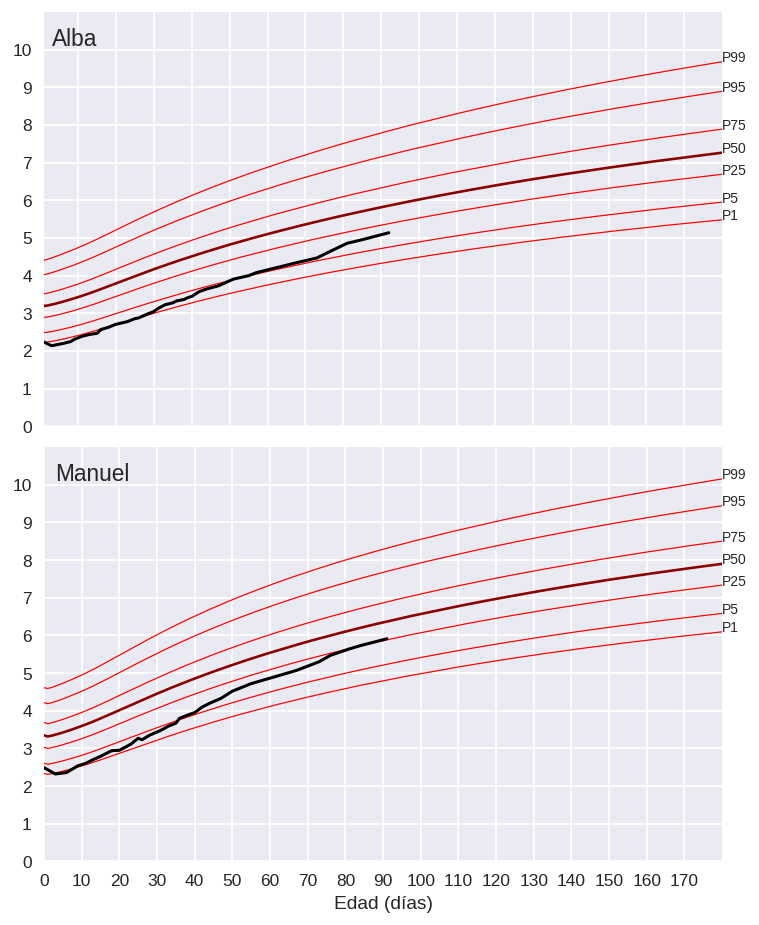

In [ ]:
# Imports (general)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
today=pd.to_datetime("today").strftime('%Y-%m-%d')

# Get permission to google drive
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Read table in Google Sheets
worksheet = gc.open("BabyWeight").sheet1 
# Convert to a DataFrame
rows = worksheet.get_all_values()
df=pd.DataFrame.from_records(rows)
df.drop([0],inplace=True)
df.rename(columns={0:"date",1:"age_days",2:"weight"},inplace=True)
df=df.set_index("date")
df.index = pd.to_datetime(df.index)

# Update dataframe and save
update=input("Do you want to update the table? Y/N: ")  # 1. Indicate if you want to update the table
if update=="Y":
  while update=="S":
    istoday=input("Data referred to today?: Y/N ")  # 3. Indicate if the weight observation refer to today
    if istoday=="Y":
      date=today  # If date is today, the date value is automatically provided
    else:
      date=input("Date: XXXX-XX-XX (Year/Month/Day): ")
    weight=input("Weight (decimals with dot): ")
    df.loc[date,"weight"]=peso
    update=input("¿Quieres actualizar MÁS la tabla? S/N: ")
  # Actualizar
  import gspread_dataframe as gd
  gd.set_with_dataframe(worksheet, df.reset_index())

# Procesamos datos
df[["a","m"]]=df[["Alba","Manuel"]]
df["a"]=pd.to_numeric(df["a"],errors='coerce')
df["m"]=pd.to_numeric(df["m"],errors='coerce')
df["edad"]=pd.to_numeric(df["edad"],errors='coerce')
# Restar peso de pañal y body (excepto primeras dos medidas en el hospital)
df.loc["2021-11-27":,["a","m"]]=df.loc["2021-11-27":,["a","m"]]-0.06
# Interpolación lineal
  # Alba
df_nona_a = df.dropna(subset = ['a'])
f = interp1d(df_nona_a['edad'], df_nona_a['a'])
fechamax_a=df["a"][pd.notnull(df.a)].idxmax()
df.loc[:fechamax_a,"a"] = f(df.loc[:fechamax_a,'edad'])
  # Manuel
df_nona_m = df.dropna(subset = ['m'])
f = interp1d(df_nona_m['edad'], df_nona_m['m'])
fechamax_m=df["m"][pd.notnull(df.m)].idxmax()
df.loc[:fechamax_m,"m"] = f(df.loc[:fechamax_m,'edad'])
  # Set Age as index
df=df.set_index("edad")

# Growth standards
girls=pd.read_csv("https://raw.githubusercontent.com/otoperalias/miscellanea/main/data/wfa_girls_p_exp.csv",sep=";", index_col=0)
boys=pd.read_csv("https://raw.githubusercontent.com/otoperalias/miscellanea/main/data/wfa_boys_p_exp.csv",sep=";", index_col=0)

  # GRÁFICO
plt.style.use('seaborn')
fig,(ax1,ax2)=plt.subplots(2,figsize=(7,9),sharex=True, dpi=125)
# Alba
girls[["P1","P5","P25","P50","P75","P95","P99"]].plot(ax=ax1, color="red",lw=0.7)
girls["P50"].plot(ax=ax1, color="darkred",lw=1.5)
df["a"].plot(ax=ax1,color="black")
ax1.get_legend().remove()
ax1.set_xlim(1,180)
ax1.set_ylim(1,11) 
ax1.text(3,10.1,"Alba",size=13)
ax1.set_yticks(np.arange(0, 11, 1))
for p in ["P1","P5","P25","P50","P75","P95","P99"]:
  ax1.text(180,girls[p].iloc[180],p,size=8)
# Manuel
boys[["P1","P5","P25","P50","P75","P95","P99"]].plot(ax=ax2, color="red",lw=0.7)
boys["P50"].plot(ax=ax2, color="darkred",lw=1.5)
df["m"].plot(ax=ax2,color="black")
ax2.get_legend().remove()
ax2.set_xlim(1,180)
ax2.set_ylim(1,11)
ax2.text(3,10.1,"Manuel",size=13)
ax2.set_xlabel("Edad (días)")
ax2.set_xticks(np.arange(0, 180, 10))
ax2.set_xticklabels([x for x in np.arange(0, 190, 10)])
ax2.set_yticks(np.arange(0, 11, 1))
for p in ["P1","P5","P25","P50","P75","P95","P99"]:
  ax2.text(180,boys[p].iloc[180],p,size=8)
plt.subplots_adjust(hspace=0.05)
plt.show()